In [1]:
import os, importlib, sys, time, h5py

In [2]:
import numpy as np
from scipy import linalg, stats, ndimage, io
from scipy.sparse import diags

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':12})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino'], 'size':12})
# rc('text', usetex=False)

In [4]:
import ladyns as ldn
import ladyns.inference as inf

# 1. simulate data

In [5]:
dims = [25, 25]
num_rtime = 500
num_trial = 1000

In [6]:
coords_S = [np.array(np.where(np.full((5,5), True))).T for _ in np.arange(2)]
sigmas_S = [0.8, 0.8]
covs_S = [np.exp(-np.sum((cd[:,None,:] - cd[None,:,:])**2,-1)
                 / (2 * sigma**2))
          for cd, sigma in zip(coords_S, sigmas_S)]

## background pink noise

In [7]:
alpha = 1.4
f = np.linspace(0, np.pi, num_rtime//2+1)[1:-1]
psd = 1/(f**alpha)

In [8]:
Ws = [np.sqrt(0.5 * psd)[:,None] * 
      np.random.multivariate_normal(np.zeros(d), cov, 
            size=(num_trial, num_rtime//2-1))
      for d, cov in zip(dims, covs_S)]
RZs = [np.concatenate([
        np.random.multivariate_normal(np.zeros(d), cov, size=(num_trial,1)), 
        W, 
        np.random.multivariate_normal(np.zeros(d), cov, size=(num_trial,1)), 
        np.flip(W, axis=1)], axis=1)
       for d, W, cov in zip(dims, Ws, covs_S)]

In [9]:
Ws = [np.sqrt(0.5 * psd)[:,None] * 
      np.random.multivariate_normal(np.zeros(d), cov, 
            size=(num_trial, num_rtime//2-1))
      for d, cov in zip(dims, covs_S)]
IZs = [np.concatenate([
        np.zeros((num_trial,1,d)), 
        W, 
        np.zeros((num_trial,1,d)), 
        np.flip(W, axis=1)], axis=1)
       for W, cov, d in zip(Ws, covs_S, dims)]

In [10]:
etas = [np.fft.irfft(RZ+ 1j*IZ, num_rtime, axis=1)
        for RZ, IZ in zip(RZs, IZs)]

In [14]:
cwt_eta = np.zeros((num_trial, len(cwt_scales), num_rtime), dtype=np.complex128)
for i in np.arange(1000):
    cwt_eta[i] = signal.cwt(etas[0][i,:,0], signal.morlet2, cwt_scales, w=cwt_omega)

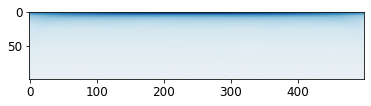

In [15]:
ldn.imshow(np.mean(np.abs(cwt_eta),0))

## beta band signal

In [598]:
f_beta = 18
ts_sig = [80, 200, 400]
ss_sig = [5000/4, 5000/4, 5000/4]
pbts = [np.exp(-np.square(np.arange(num_rtime) - t)/s)
       for t, s in zip(ts_sig, ss_sig)]

In [599]:
Ws = [np.random.normal(scale=pbt, size=(num_trial,num_rtime))
      for pbt in pbts]

In [600]:
cwt_omega = 3
cwt_scale = cwt_omega * 1000 / (2 * f_beta * np.pi)

In [601]:
beta_map = signal.morlet2(num_rtime, w=cwt_omega, s=cwt_scale)

In [602]:
sigs =  [np.real(signal.convolve(W, beta_map[None,:]))
        for W in Ws]

### plots

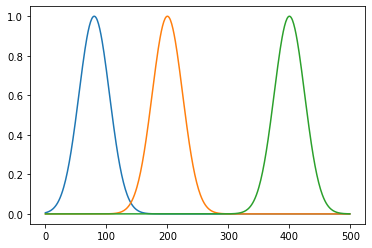

In [603]:
plt.plot(pbts[0])
plt.plot(pbts[1])
plt.plot(pbts[2])

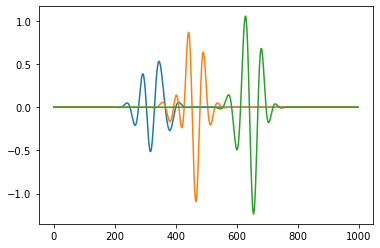

In [604]:
plt.plot(sigs[0][0])
plt.plot(sigs[1][0])
plt.plot(sigs[2][0])

In [591]:
cwt_omega = 3
cwt_scales = cwt_omega * 1000 / (2 * (np.arange(100)+1) * np.pi)

In [592]:
cwts_sig = [signal.cwt(sig[0], signal.morlet2, cwt_scales, w=cwt_omega)
           for sig in sigs]

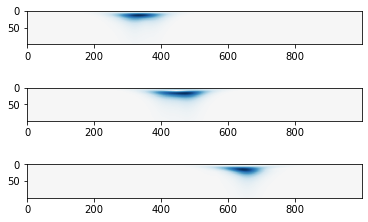

In [501]:
plt.subplot(3,1,1); ldn.imshow(np.abs(cwts_sig[0]))
plt.subplot(3,1,2); ldn.imshow(np.abs(cwts_sig[1]))
plt.subplot(3,1,3); ldn.imshow(np.abs(cwts_sig[2]))

# observation

In [605]:
ctrs = [[(1, 1), (3, 3), (2, 2)],
        [(3, 3), (1, 1), (2, 2)]]
lags = [[0, 30, 30],
        [30, 0, 0]]
ws = [[np.sqrt(0.006), np.sqrt(0.006), np.sqrt(0.006)],
      [np.sqrt(0.006), np.sqrt(0.006), np.sqrt(0.006)]]

In [606]:
betas = [[np.exp(-np.sum((cd-ct)**2,-1)/(2*sig**2))
          for ct in ctr]
         for cd, ctr, sig in zip(coords_S, ctrs, sigmas_S)] 

In [607]:
obss = [eta + w[0] * beta[0] * sigs[0][:,num_rtime//2-lag[0]:-num_rtime//2-lag[0]+1,None]
            + w[1] * beta[1] * sigs[1][:,num_rtime//2-lag[1]:-num_rtime//2-lag[1]+1,None]
            + w[2] * beta[2] * sigs[2][:,num_rtime//2-lag[2]:-num_rtime//2-lag[2]+1,None]
        for eta, beta, lag, w in zip(etas, betas, lags, ws)]

## plot

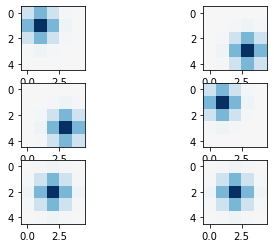

In [608]:
plt.subplot(3,2,1); ldn.imshow(betas[0][0].reshape((5,5)))
plt.subplot(3,2,2); ldn.imshow(betas[1][0].reshape((5,5)))
plt.subplot(3,2,3); ldn.imshow(betas[0][1].reshape((5,5)))
plt.subplot(3,2,4); ldn.imshow(betas[1][1].reshape((5,5)))
plt.subplot(3,2,5); ldn.imshow(betas[0][2].reshape((5,5)))
plt.subplot(3,2,6); ldn.imshow(betas[1][2].reshape((5,5)))

In [609]:
cwt_omega = 3
cwt_scales = cwt_omega * 1000 / (2 * (np.arange(100)+1) * np.pi)

In [610]:
cwt_obs = [np.zeros((d, len(cwt_scales), num_rtime), dtype=np.complex128)
           for d in dims]
for k, d in enumerate(dims):
    for i in np.arange(d):
        cwt_obs[k][i] = signal.cwt(obss[k][0,:,i], signal.morlet2, cwt_scales, w=cwt_omega)

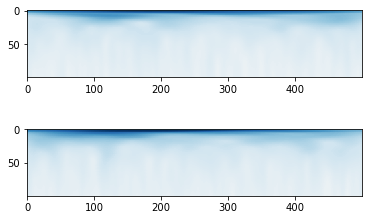

In [611]:
plt.subplot(2,1,1); ldn.imshow(np.mean(np.abs(cwt_obs[0]),0))
plt.subplot(2,1,2); ldn.imshow(np.mean(np.abs(cwt_obs[1]),0))

# 2. pre-processing

In [619]:
cwt_omega = 3 
cwt_scale = cwt_omega * 1000 / (2 * f_beta * np.pi)

In [620]:
filter_map = signal.morlet2(num_rtime, cwt_scale, cwt_omega)

In [621]:
data = [np.zeros((num_rtime//10, d , num_trial)) for d in dims]

In [622]:
for l, d in enumerate(dims):
    for i in np.arange(d):
        data[l][:,i,:] = np.abs(signal.convolve(obss[l][:,:,i], 
                filter_map[None,:], mode='same')[:,::10]).T

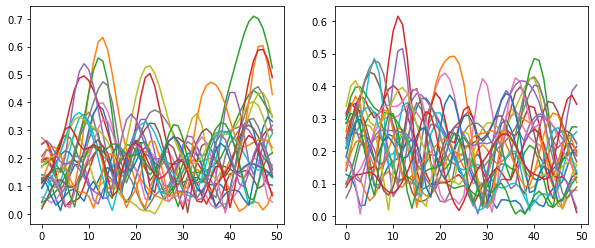

In [623]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1); plt.plot(data[0][:,:,0])
plt.subplot(1,2,2); plt.plot(data[1][:,:,0])
plt.show()

# 3. parameter calibration

In [627]:
rec_time = [0, 500]
num_time = data[0].shape[0]

## diagonal regularization

In [628]:
cwt_omega = 3
cwt_scale = cwt_omega * 100 / (2 * f_beta * np.pi)

In [629]:
lambdas_diag = np.array([1, 2, 3, 5, 10, 20, 30, 50, 100, 200])
W_diagmean = np.zeros([len(lambdas_diag), num_time-1])
SW_ratio = np.zeros(len(lambdas_diag))
SW_error = np.zeros(len(lambdas_diag))

In [630]:
filter_mat = np.exp(-0.5*((np.arange(num_time)[:,None]
                          -np.arange(num_time))/cwt_scale)**2)
filter_mat[np.eye(num_time).astype(bool)]=0

In [631]:
for i, l_i in enumerate(lambdas_diag):
    Omegas_bar = np.concatenate([
    np.array([np.linalg.inv(np.corrcoef(dat[:,i,:]) + l_i * np.eye(num_time)) 
              for i in np.arange(d)])
    for d, dat in zip(dims, data)])
    Omegas_bar[np.array([np.eye(num_time).astype(bool)]*np.sum(dims))]=0
    
    W_diagmean[i] = np.array([
        np.mean(np.diagonal(np.mean(Omegas_bar, 0), k))
        for k in np.arange(1,num_time)
    ])
    
    SW_ratio[i] = np.sum(filter_mat*Omegas_bar) / np.sum(Omegas_bar**2)

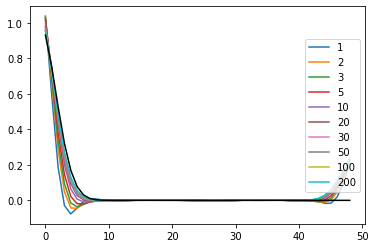

In [632]:
lineObjects = plt.plot(SW_ratio * W_diagmean.T)
plt.plot(np.exp(-0.5*(np.arange(1,num_time)/cwt_scale)**2),
         color='black')
plt.legend(iter(lineObjects), lambdas_diag, loc='right')

In [633]:
np.sum((SW_ratio[:,None] * W_diagmean 
 - np.array(
     [np.mean(np.diagonal(filter_mat, k)) 
      for k in np.arange(1,num_time)]))**2, 1)

array([0.4096237 , 0.28672808, 0.2311532 , 0.1797108 , 0.13826277,
       0.11846172, 0.11249409, 0.10812916, 0.1051761 , 0.10382641])

## calibration by permutation

In [634]:
offset_cross=10
offset_auto=10
lambdas= np.vstack([
    np.exp(np.linspace(np.log(0.1), np.log(0.001), 11)), #np.full((11,), 0.06), ## lambdas_cross
    np.zeros(11), ## lambdas_auto
    np.full((11,), 20), ## lambdas_diag
    np.zeros(11)]) ## lambdas_ridge

In [635]:
time_graph_cross = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_cross)
time_graph_auto = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_auto)

In [636]:
b_time = np.linspace(rec_time[0], rec_time[1], num_time)
l_time = np.linspace(rec_time[0], rec_time[1], 2*num_time-1)

In [637]:
num_cv = 10

In [427]:
Omegas_cv = np.zeros([num_cv, lambdas.shape[-1], 2*num_time, 2*num_time])
weights_cv = []

for iter_cv in np.arange(num_cv):
    start_cv = time.time()
    
    # random sample
    trial_sample = np.random.choice(num_trial, num_trial, False)
    data_bst = [data[0], data[1][:,:,trial_sample]]

    for iter_est, (lambda_cross, lambda_auto, lambda_diag, lambda_ridge) \
    in enumerate(zip(*lambdas)): 
        if iter_cv > 0:
            init_arg = {'Omega_init': Omegas_cv[0,iter_est],
                        'weight_init': weights_cv[iter_est]}
        elif iter_est > 0:
            init_arg = {'Omega_init': Omegas_cv[0,iter_est-1],
                        'weight_init': weights_cv[iter_est-1]}
        else:
            init_arg = dict()

        Omega_est, Sigma_est, latent_est, weight_est \
        = ldn.fit(data_bst, lambda_diag, lambda_cross, offset_cross,
                   lambda_auto, offset_auto, 
                   ths_glasso=1e-6, ths_lasso=1e-6, verbose=True,
                   **init_arg)
        
        # save result
        Omegas_cv[iter_cv, iter_est] = Omega_est
        if iter_cv == 0:
            weights_cv.append(weight_est)

    sys.__stdout__.write("%d-th cv finished, lapse: %.3fsec.\n"
                         %(iter_cv+1, time.time()-start_cv))
    sys.__stdout__.flush()

1-th iter, nll: 404.099506, change: 0.231842, lapse: 0.172081
2-th iter, nll: 404.092238, change: 0.050280, lapse: 0.171731
3-th iter, nll: 404.086242, change: 0.036531, lapse: 0.173908
4-th iter, nll: 404.081218, change: 0.031899, lapse: 0.172563
5-th iter, nll: 404.077040, change: 0.026326, lapse: 0.174271
6-th iter, nll: 404.073584, change: 0.020543, lapse: 0.171236
7-th iter, nll: 404.070720, change: 0.017992, lapse: 0.174401
8-th iter, nll: 404.068334, change: 0.015417, lapse: 0.171538
9-th iter, nll: 404.066338, change: 0.013755, lapse: 0.174263
10-th iter, nll: 404.064667, change: 0.012721, lapse: 0.171305
11-th iter, nll: 404.063268, change: 0.011943, lapse: 0.173744
12-th iter, nll: 404.062097, change: 0.010850, lapse: 0.171569
13-th iter, nll: 404.061118, change: 0.009579, lapse: 0.176420
14-th iter, nll: 404.060300, change: 0.008262, lapse: 0.173480
15-th iter, nll: 404.059615, change: 0.006997, lapse: 0.177929
16-th iter, nll: 404.059039, change: 0.005847, lapse: 0.171985
1

10-th iter, nll: 404.054380, change: 0.000979, lapse: 0.103738
1-th iter, nll: 404.054477, change: 0.128738, lapse: 0.110265
2-th iter, nll: 404.054351, change: 0.005274, lapse: 0.111630
3-th iter, nll: 404.054279, change: 0.003033, lapse: 0.109063
4-th iter, nll: 404.054233, change: 0.002140, lapse: 0.103412
5-th iter, nll: 404.054202, change: 0.001836, lapse: 0.101812
6-th iter, nll: 404.054179, change: 0.001632, lapse: 0.103202
7-th iter, nll: 404.054163, change: 0.001462, lapse: 0.102541
8-th iter, nll: 404.054150, change: 0.001312, lapse: 0.104732
9-th iter, nll: 404.054140, change: 0.001185, lapse: 0.109960
10-th iter, nll: 404.054132, change: 0.001079, lapse: 0.103848
11-th iter, nll: 404.054126, change: 0.000991, lapse: 0.101783
1-th iter, nll: 404.054343, change: 0.133817, lapse: 0.120152
2-th iter, nll: 404.054201, change: 0.005531, lapse: 0.108921
3-th iter, nll: 404.054120, change: 0.003199, lapse: 0.111780
4-th iter, nll: 404.054068, change: 0.002241, lapse: 0.108872
5-th 

6-th iter, nll: 404.053106, change: 0.003514, lapse: 0.113277
7-th iter, nll: 404.053062, change: 0.003037, lapse: 0.110445
8-th iter, nll: 404.053027, change: 0.002655, lapse: 0.113531
9-th iter, nll: 404.052999, change: 0.002341, lapse: 0.111106
10-th iter, nll: 404.052975, change: 0.002080, lapse: 0.112227
11-th iter, nll: 404.052955, change: 0.001860, lapse: 0.109974
12-th iter, nll: 404.052938, change: 0.001678, lapse: 0.112268
13-th iter, nll: 404.052924, change: 0.001532, lapse: 0.110200
14-th iter, nll: 404.052912, change: 0.001402, lapse: 0.113009
15-th iter, nll: 404.052902, change: 0.001285, lapse: 0.110046
16-th iter, nll: 404.052893, change: 0.001180, lapse: 0.112798
17-th iter, nll: 404.052886, change: 0.001085, lapse: 0.113075
18-th iter, nll: 404.052879, change: 0.000999, lapse: 0.112550
1-th iter, nll: 404.053482, change: 0.134980, lapse: 0.119611
2-th iter, nll: 404.053253, change: 0.009010, lapse: 0.113871
3-th iter, nll: 404.053107, change: 0.006481, lapse: 0.110249

9-th iter, nll: 404.053826, change: 0.001336, lapse: 0.114452
10-th iter, nll: 404.053814, change: 0.001273, lapse: 0.111128
11-th iter, nll: 404.053803, change: 0.001214, lapse: 0.113487
12-th iter, nll: 404.053794, change: 0.001161, lapse: 0.112433
13-th iter, nll: 404.053785, change: 0.001116, lapse: 0.112961
14-th iter, nll: 404.053778, change: 0.001069, lapse: 0.110747
15-th iter, nll: 404.053771, change: 0.001025, lapse: 0.112466
16-th iter, nll: 404.053765, change: 0.000982, lapse: 0.102583
1-th iter, nll: 404.054055, change: 0.147975, lapse: 0.121693
2-th iter, nll: 404.053905, change: 0.005404, lapse: 0.110594
3-th iter, nll: 404.053818, change: 0.003175, lapse: 0.112533
4-th iter, nll: 404.053761, change: 0.002594, lapse: 0.111554
5-th iter, nll: 404.053719, change: 0.002192, lapse: 0.112664
6-th iter, nll: 404.053688, change: 0.001889, lapse: 0.110878
7-th iter, nll: 404.053663, change: 0.001661, lapse: 0.113157
8-th iter, nll: 404.053643, change: 0.001551, lapse: 0.109884
9

6-th iter, nll: 404.053966, change: 0.002237, lapse: 0.112218
7-th iter, nll: 404.053945, change: 0.001785, lapse: 0.111277
8-th iter, nll: 404.053928, change: 0.001478, lapse: 0.113263
9-th iter, nll: 404.053915, change: 0.001249, lapse: 0.111325
10-th iter, nll: 404.053903, change: 0.001221, lapse: 0.114737
11-th iter, nll: 404.053894, change: 0.001197, lapse: 0.111133
12-th iter, nll: 404.053886, change: 0.001167, lapse: 0.112686
13-th iter, nll: 404.053879, change: 0.001135, lapse: 0.111440
14-th iter, nll: 404.053872, change: 0.001097, lapse: 0.112753
15-th iter, nll: 404.053867, change: 0.001061, lapse: 0.103159
16-th iter, nll: 404.053862, change: 0.001025, lapse: 0.105798
17-th iter, nll: 404.053857, change: 0.000994, lapse: 0.103257
1-th iter, nll: 404.054182, change: 0.172632, lapse: 0.122425
2-th iter, nll: 404.054017, change: 0.008169, lapse: 0.112189
3-th iter, nll: 404.053920, change: 0.005866, lapse: 0.119956
4-th iter, nll: 404.053857, change: 0.004128, lapse: 0.111255


9-th iter, nll: 404.054178, change: 0.001218, lapse: 0.112276
10-th iter, nll: 404.054171, change: 0.001090, lapse: 0.110559
11-th iter, nll: 404.054166, change: 0.000987, lapse: 0.112290
1-th iter, nll: 404.054196, change: 0.199827, lapse: 0.118278
2-th iter, nll: 404.054073, change: 0.008528, lapse: 0.113488
3-th iter, nll: 404.054002, change: 0.004873, lapse: 0.110797
4-th iter, nll: 404.053954, change: 0.003065, lapse: 0.114052
5-th iter, nll: 404.053921, change: 0.002366, lapse: 0.111396
6-th iter, nll: 404.053895, change: 0.002092, lapse: 0.112305
7-th iter, nll: 404.053876, change: 0.001882, lapse: 0.110309
8-th iter, nll: 404.053861, change: 0.001683, lapse: 0.112709
9-th iter, nll: 404.053850, change: 0.001507, lapse: 0.110323
10-th iter, nll: 404.053840, change: 0.001352, lapse: 0.112802
11-th iter, nll: 404.053832, change: 0.001216, lapse: 0.110462
12-th iter, nll: 404.053826, change: 0.001099, lapse: 0.113675
13-th iter, nll: 404.053821, change: 0.000994, lapse: 0.111098
1-

7-th iter, nll: 404.054022, change: 0.001585, lapse: 0.113094
8-th iter, nll: 404.054001, change: 0.001384, lapse: 0.111760
9-th iter, nll: 404.053985, change: 0.001231, lapse: 0.113387
10-th iter, nll: 404.053971, change: 0.001112, lapse: 0.103046
11-th iter, nll: 404.053960, change: 0.001017, lapse: 0.105384
12-th iter, nll: 404.053950, change: 0.000939, lapse: 0.104202
1-th iter, nll: 404.054299, change: 0.169507, lapse: 0.122595
2-th iter, nll: 404.054129, change: 0.006888, lapse: 0.113201
3-th iter, nll: 404.054024, change: 0.004493, lapse: 0.114238
4-th iter, nll: 404.053953, change: 0.003267, lapse: 0.111133
5-th iter, nll: 404.053901, change: 0.002526, lapse: 0.114047
6-th iter, nll: 404.053863, change: 0.002000, lapse: 0.111029
7-th iter, nll: 404.053833, change: 0.001696, lapse: 0.113657
8-th iter, nll: 404.053810, change: 0.001481, lapse: 0.111452
9-th iter, nll: 404.053791, change: 0.001318, lapse: 0.113625
10-th iter, nll: 404.053776, change: 0.001191, lapse: 0.111392
11-t

15-th iter, nll: 404.053669, change: 0.001185, lapse: 0.104991
16-th iter, nll: 404.053665, change: 0.001052, lapse: 0.102503
17-th iter, nll: 404.053661, change: 0.000935, lapse: 0.105246
1-th iter, nll: 404.053981, change: 0.155227, lapse: 0.118908
2-th iter, nll: 404.053793, change: 0.009459, lapse: 0.119949
3-th iter, nll: 404.053674, change: 0.007221, lapse: 0.111408
4-th iter, nll: 404.053591, change: 0.006033, lapse: 0.113011
5-th iter, nll: 404.053531, change: 0.004865, lapse: 0.110941
6-th iter, nll: 404.053486, change: 0.004023, lapse: 0.113756
7-th iter, nll: 404.053451, change: 0.003410, lapse: 0.111232
8-th iter, nll: 404.053424, change: 0.002936, lapse: 0.114451
9-th iter, nll: 404.053402, change: 0.002550, lapse: 0.111422
10-th iter, nll: 404.053384, change: 0.002226, lapse: 0.104613
11-th iter, nll: 404.053370, change: 0.001949, lapse: 0.102833
12-th iter, nll: 404.053359, change: 0.001711, lapse: 0.104685
13-th iter, nll: 404.053349, change: 0.001505, lapse: 0.102491
1

9-th iter, nll: 404.053913, change: 0.001450, lapse: 0.113392
10-th iter, nll: 404.053902, change: 0.001278, lapse: 0.111182
11-th iter, nll: 404.053893, change: 0.001127, lapse: 0.113734
12-th iter, nll: 404.053885, change: 0.000999, lapse: 0.111007
1-th iter, nll: 404.054172, change: 0.150150, lapse: 0.122871
2-th iter, nll: 404.054014, change: 0.006034, lapse: 0.112073
3-th iter, nll: 404.053921, change: 0.004094, lapse: 0.114547
4-th iter, nll: 404.053859, change: 0.003227, lapse: 0.111541
5-th iter, nll: 404.053815, change: 0.002725, lapse: 0.113648
6-th iter, nll: 404.053782, change: 0.002382, lapse: 0.111585
7-th iter, nll: 404.053757, change: 0.002069, lapse: 0.113863
8-th iter, nll: 404.053737, change: 0.001807, lapse: 0.111798
9-th iter, nll: 404.053721, change: 0.001587, lapse: 0.114490
10-th iter, nll: 404.053708, change: 0.001402, lapse: 0.111695
11-th iter, nll: 404.053698, change: 0.001248, lapse: 0.114778
12-th iter, nll: 404.053689, change: 0.001114, lapse: 0.111143
13

4-th iter, nll: 404.053582, change: 0.003476, lapse: 0.113207
5-th iter, nll: 404.053531, change: 0.002968, lapse: 0.110621
6-th iter, nll: 404.053494, change: 0.002541, lapse: 0.113291
7-th iter, nll: 404.053466, change: 0.002200, lapse: 0.110556
8-th iter, nll: 404.053445, change: 0.001922, lapse: 0.113531
9-th iter, nll: 404.053429, change: 0.001692, lapse: 0.110828
10-th iter, nll: 404.053416, change: 0.001500, lapse: 0.113530
11-th iter, nll: 404.053405, change: 0.001340, lapse: 0.110285
12-th iter, nll: 404.053396, change: 0.001207, lapse: 0.113920
13-th iter, nll: 404.053388, change: 0.001098, lapse: 0.111268
14-th iter, nll: 404.053382, change: 0.001005, lapse: 0.112519
15-th iter, nll: 404.053376, change: 0.000925, lapse: 0.103235
1-th iter, nll: 404.053900, change: 0.170737, lapse: 0.122974
2-th iter, nll: 404.053697, change: 0.007118, lapse: 0.111089
3-th iter, nll: 404.053576, change: 0.004763, lapse: 0.114708
4-th iter, nll: 404.053498, change: 0.003574, lapse: 0.111196
5-

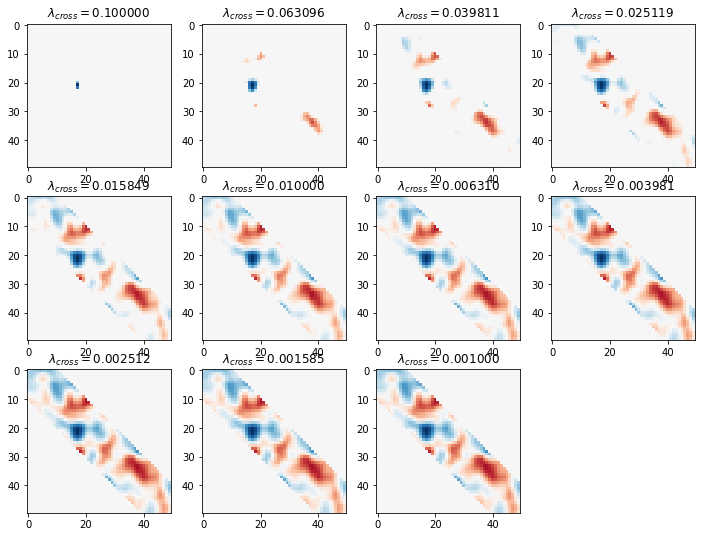

In [428]:
plt.figure(figsize=(12,3*np.ceil(lambdas.shape[-1]/4)))
for iter_lambda, (lambda_cross, lambda_auto, lambda_diag, lambda_ridge) \
in enumerate(zip(*lambdas)):
    plt.subplot(np.ceil(lambdas.shape[-1]/4), 4, iter_lambda+1)
    ldn.imshow(Omegas_cv[0, iter_lambda,:num_time,num_time:], identity=True)
    plt.title(r'$\lambda_{cross} = %f$'%lambda_cross)

In [429]:
fds_cv = np.sum(Omegas_cv[:,:,:num_time,num_time:]!=0,(0,-2,-1))/num_cv
fdrs_cv = np.sum(Omegas_cv[:,:,:num_time,num_time:]!=0,(0,-2,-1))/np.sum(time_graph_cross)/num_cv

Text(0, 0.5, 'mean false discovery')

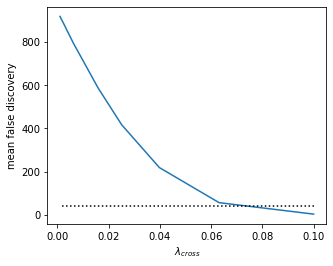

In [430]:
plt.figure(figsize=(5,4))
plt.plot(lambdas[0], fds_cv)
plt.plot(lambdas[0], np.full(lambdas[0].shape, 0.05*np.sum(time_graph_cross)), color='black', linestyle=':')
plt.xlabel(r"$\lambda_{cross}$")
plt.ylabel(r"mean false discovery")

In [431]:
id_cv = np.argmax(fdrs_cv[fdrs_cv < 0.05])

In [432]:
lambda_cross, lambda_auto, lambda_diag, lambda_ridge = lambdas.T[id_cv]
lambda_cross, lambda_auto, lambda_diag, lambda_ridge

(0.10000000000000002, 0.0, 20.0, 0.0)

# 4. LaDynS

In [638]:
Omega_est, Sigma_est, latent_est, weight_est =\
    ldn.fit(data, lambda_diag, lambda_cross, offset_cross,
            lambda_auto, offset_auto, 
            ths_glasso=1e-6, ths_lasso=1e-6, verbose=True)

1-th iter, nll: 404.105360, change: 0.226454, lapse: 0.210904
2-th iter, nll: 404.099525, change: 0.046800, lapse: 0.184113
3-th iter, nll: 404.094640, change: 0.035069, lapse: 0.239444
4-th iter, nll: 404.090317, change: 0.027636, lapse: 0.211423
5-th iter, nll: 404.086437, change: 0.024555, lapse: 0.167222
6-th iter, nll: 404.082966, change: 0.023094, lapse: 0.179615
7-th iter, nll: 404.079883, change: 0.023902, lapse: 0.151400
8-th iter, nll: 404.077176, change: 0.023511, lapse: 0.188806
9-th iter, nll: 404.074834, change: 0.022121, lapse: 0.139770
10-th iter, nll: 404.072829, change: 0.020226, lapse: 0.119489
11-th iter, nll: 404.071129, change: 0.018385, lapse: 0.177737
12-th iter, nll: 404.069695, change: 0.016246, lapse: 0.243387
13-th iter, nll: 404.068488, change: 0.013814, lapse: 0.259359
14-th iter, nll: 404.067470, change: 0.011514, lapse: 0.203099
15-th iter, nll: 404.066609, change: 0.009489, lapse: 0.117739
16-th iter, nll: 404.065877, change: 0.007716, lapse: 0.120427
1

## plots

Text(0, 0.5, 'series 1 at time $t$ ms')

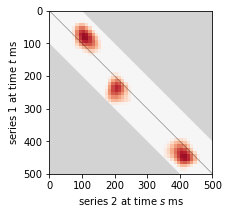

In [699]:
fig, ax = plt.subplots(figsize=(4,3))
ldn.imshow(Omega_est[:num_time,num_time:], time=rec_time, identity=True, vmax=0.0004)

ax.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
ax.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')
# cbar = plt.colorbar(ticks=[-0.002, -0.001, 0.0, 0.001, 0.002])
# cbar.ax.set_yticklabels(['-2e-3','-1e-3','0','1e-3','2e-3'])
ax.set_xlim(rec_time[0], rec_time[1]); ax.set_ylim(rec_time[1], rec_time[0])
plt.xlabel(r"series 2 at time $s$ ms"); plt.ylabel(r"series 1 at time $t$ ms")

Text(0, 0.5, 'series 1 at time $t$')

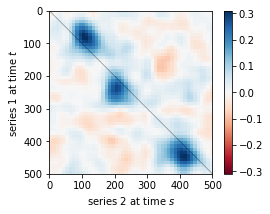

In [643]:
plt.figure(figsize=(4,3))
ldn.imshow(Sigma_est[:num_time,num_time:], time=rec_time, identity=True); plt.colorbar()
plt.xlabel(r"series 2 at time $s$"); plt.ylabel(r"series 1 at time $t$")

Text(0, 0.5, 'V4 at time $s$ sec.')

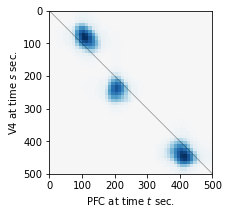

In [644]:
plt.figure(figsize=(3,3))
ldn.imshow(np.linalg.inv(Omega_est)[:num_time,num_time:], time=rec_time, identity=True)
plt.xlabel(r"PFC at time $t$ sec."); plt.ylabel(r"V4 at time $s$ sec.")

# 5. Permutation test

In [645]:
num_perm = 200

In [646]:
init_arg = {'Omega_init': Omegas_cv[0,id_cv],
            'weight_init': weights_cv[id_cv]}

In [647]:
Omegas_perm = np.zeros([num_perm, 2*num_time, 2*num_time])
Sigmas_perm = np.zeros([num_perm, 2*num_time, 2*num_time])

for iter_perm in range(num_perm):    
    while True:
        with np.errstate(all='raise'):
            try:
                start_perm = time.time()
                
                # random sample
                trial_sample = np.random.choice(num_trial, num_trial, False)
                data_bst = [data[0], data[1][:,:,trial_sample]]

                # permutation
                Omega_perm, Sigma_perm, latent_perm, weight_perm \
                = ldn.fit(data_bst, lambda_diag, lambda_cross, offset_cross,
                          lambda_auto, offset_auto, 
                          ths_glasso=1e-6, ths_lasso=1e-6, verbose=True,
                          **init_arg)
        
                
            except FloatingPointError:
                sys.__stdout__.write("%d-th permutation encountered FloatingPointError, lapse:%.3fsec.\n"
                                     %(iter_perm+1, time.time()-start_perm))
                sys.__stdout__.write("Retrying...\n")
                sys.__stdout__.flush()
                continue
                
            init_arg = {'Omega_init':Omega_perm, 'weight_init':weight_perm}
                        
            # save result
            Omegas_perm[iter_perm] = Omega_perm
            Sigmas_perm[iter_perm] = Sigma_perm
            
            sys.__stdout__.write("%d-th permutation finished, lapse: %.3fsec.\n"
                          %(iter_perm+1, time.time()-start_perm))
            sys.__stdout__.flush()
            break

1-th iter, nll: 404.072906, change: 0.190885, lapse: 0.336067
2-th iter, nll: 404.069872, change: 0.027439, lapse: 0.271681
3-th iter, nll: 404.068158, change: 0.014848, lapse: 0.276373
4-th iter, nll: 404.067062, change: 0.009995, lapse: 0.309900
5-th iter, nll: 404.066313, change: 0.007057, lapse: 0.294136
6-th iter, nll: 404.065779, change: 0.005697, lapse: 0.256632
7-th iter, nll: 404.065385, change: 0.005036, lapse: 0.278911
8-th iter, nll: 404.065087, change: 0.004464, lapse: 0.245321
9-th iter, nll: 404.064858, change: 0.003967, lapse: 0.139989
10-th iter, nll: 404.064677, change: 0.003523, lapse: 0.119055
1-th permutation encountered FloatingPointError, lapse:2.725sec.
Retrying...
1-th iter, nll: 404.072906, change: 0.190885, lapse: 0.189040
2-th iter, nll: 404.069872, change: 0.027439, lapse: 0.290676
3-th iter, nll: 404.068158, change: 0.014848, lapse: 0.331569
4-th iter, nll: 404.067062, change: 0.009995, lapse: 0.270588
5-th iter, nll: 404.066313, change: 0.007057, lapse: 0

1-th iter, nll: 404.063724, change: 0.000377, lapse: 0.262972
21-th permutation finished, lapse: 0.331sec.
1-th iter, nll: 404.063722, change: 0.002181, lapse: 0.248953
2-th iter, nll: 404.063720, change: 0.000371, lapse: 0.252709
22-th permutation finished, lapse: 0.561sec.
1-th iter, nll: 404.063718, change: 0.002209, lapse: 0.300554
2-th iter, nll: 404.063716, change: 0.000366, lapse: 0.289202
23-th permutation finished, lapse: 0.656sec.
1-th iter, nll: 404.063715, change: 0.000363, lapse: 0.239016
24-th permutation finished, lapse: 0.307sec.
1-th iter, nll: 404.063713, change: 0.000361, lapse: 0.280836
25-th permutation finished, lapse: 0.334sec.
1-th iter, nll: 404.063711, change: 0.000358, lapse: 0.310400
26-th permutation finished, lapse: 0.393sec.
1-th iter, nll: 404.063710, change: 0.000356, lapse: 0.258433
27-th permutation finished, lapse: 0.335sec.
1-th iter, nll: 404.063708, change: 0.000353, lapse: 0.324781
28-th permutation finished, lapse: 0.384sec.
1-th iter, nll: 404.

1-th iter, nll: 404.063658, change: 0.000221, lapse: 0.163199
85-th permutation finished, lapse: 0.202sec.
1-th iter, nll: 404.063657, change: 0.012494, lapse: 0.163006
2-th iter, nll: 404.063656, change: 0.000219, lapse: 0.164512
86-th permutation finished, lapse: 0.363sec.
1-th iter, nll: 404.063657, change: 0.012710, lapse: 0.142702
2-th iter, nll: 404.063656, change: 0.000217, lapse: 0.135589
87-th permutation finished, lapse: 0.321sec.
1-th iter, nll: 404.063656, change: 0.000216, lapse: 0.245238
88-th permutation finished, lapse: 0.281sec.
1-th iter, nll: 404.063656, change: 0.000215, lapse: 0.161635
89-th permutation finished, lapse: 0.221sec.
1-th iter, nll: 404.063656, change: 0.000214, lapse: 0.186203
90-th permutation finished, lapse: 0.223sec.
1-th iter, nll: 404.063655, change: 0.000214, lapse: 0.212573
91-th permutation finished, lapse: 0.248sec.
1-th iter, nll: 404.063655, change: 0.000213, lapse: 0.304103
92-th permutation finished, lapse: 0.344sec.
1-th iter, nll: 404.

1-th iter, nll: 404.063638, change: 0.000184, lapse: 0.254624
145-th permutation finished, lapse: 0.316sec.
1-th iter, nll: 404.063638, change: 0.000184, lapse: 0.183686
146-th permutation finished, lapse: 0.230sec.
1-th iter, nll: 404.063638, change: 0.000184, lapse: 0.220150
147-th permutation finished, lapse: 0.260sec.
1-th iter, nll: 404.063638, change: 0.000184, lapse: 0.169256
148-th permutation finished, lapse: 0.212sec.
1-th iter, nll: 404.063637, change: 0.000184, lapse: 0.239497
149-th permutation finished, lapse: 0.282sec.
1-th iter, nll: 404.063637, change: 0.000184, lapse: 0.316689
150-th permutation finished, lapse: 0.388sec.
1-th iter, nll: 404.063637, change: 0.000184, lapse: 0.164108
151-th permutation finished, lapse: 0.251sec.
1-th iter, nll: 404.063637, change: 0.000184, lapse: 0.224293
152-th permutation finished, lapse: 0.264sec.
1-th iter, nll: 404.063637, change: 0.000184, lapse: 0.162191
153-th permutation finished, lapse: 0.197sec.
1-th iter, nll: 404.063636, 

# 6. FDR inference on Cross-precision

In [697]:
alpha = 0.05
roi = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_cross-1)

In [698]:
dspr_est = 2*Omega_est - Omega_est@(Sigma_est + lambda_diag*np.eye(2*num_time))@Omega_est
dsprs_perm = 2*Omegas_perm - Omegas_perm@(Sigmas_perm + lambda_diag*np.eye(2*num_time))@Omegas_perm

In [701]:
dist_dspr_est = (dspr_est[:num_time,num_time:] / np.std(dsprs_perm[:,:num_time,num_time:],0))
dist_dspr_perm = (dsprs_perm[:,:num_time,num_time:]
                 / np.std(dsprs_perm[:,:num_time,num_time:],0))

In [703]:
pval_est = np.full(dist_dspr_est.shape, 0.5)
pvals_perm = np.full(dist_dspr_perm.shape, 0.5)
pval_est[roi] = np.clip(2*stats.norm.cdf(-np.abs(dist_dspr_est[roi])), 1e-10, 1-1e-10)
pvals_perm[:,roi] = np.clip(2*stats.norm.cdf(-np.abs(dist_dspr_perm[:,roi])), 1e-10, 1-1e-10)

In [706]:
p_sorted = np.concatenate([[0], np.sort(pval_est[roi])])
k_hat = np.max(np.where(np.linspace(0, alpha, np.sum(roi)+1) >= p_sorted))        
rej_BH = pval_est <= k_hat * alpha / np.sum(roi)

## plots

([<matplotlib.axis.YTick at 0x7f7f13a6dbd0>,
 <a list of 6 Text yticklabel objects>)

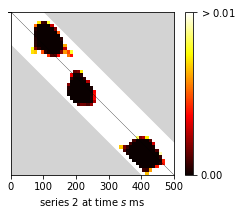

In [705]:
plt.figure(figsize=(4,3))
ldn.imshow(pval_est, cmap='hot', vmin=0, vmax=0.01, time=rec_time, identity=True)
plt.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
plt.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')

cbar = plt.colorbar(ticks=[0, 0.01])
cbar.ax.set_yticklabels(['0.00','$>$0.01'])
plt.xlabel(r"series 2 at time $s$ ms"); # plt.ylabel(r"series 1 at time $t$")
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5], ['','','','','','',''])

Text(0, 0.5, 'V4 at time $s$ sec.')

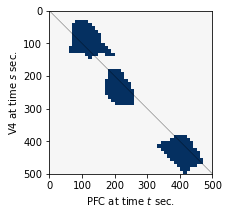

In [707]:
plt.figure(figsize=(3,3))
ldn.imshow(rej_BH * roi, time=rec_time, identity=True)
plt.xlabel(r"PFC at time $t$ sec."); plt.ylabel(r"V4 at time $s$ sec.")

([<matplotlib.axis.YTick at 0x7f7f138fb1d0>,
 <a list of 6 Text yticklabel objects>)

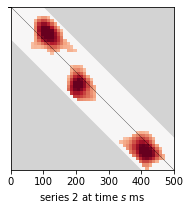

In [708]:
fig, ax = plt.subplots(figsize=(3,3))
ldn.imshow(rej_BH * dspr_est[:num_time,num_time:], time=rec_time, identity=True, vmax=0.0004)

ax.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
ax.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')
# cbar = plt.colorbar(ticks=[-0.001, -0.0005, 0.0, 0.0005, 0.001])
# cbar.ax.set_yticklabels(['-2e-3','-1e-3','0','1e-3','2e-3'])
ax.set_xlim(rec_time[0], rec_time[1]); ax.set_ylim(rec_time[1], rec_time[0])
plt.xlabel(r"series 2 at time $s$ ms"); # plt.ylabel(r"series 1 at time $t$")
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5], ['','','','','','',''])

## excursion test

In [663]:
ths_nv = k_hat * alpha / np.sum(roi)

In [664]:
rej_nv = pval_est <= ths_nv
rejs_nv_perm = pvals_perm < ths_nv

In [665]:
rejs_blobs_perm = np.zeros((num_perm, num_time, num_time))
nums_blobs_perm = np.zeros((num_perm,))

for iter_perm in range(num_perm):
    mask_cp = rejs_nv_perm[iter_perm]; iter_blob = 0
    while np.any(mask_cp):
        iter_blob += 1
        queue = [tuple(np.transpose(np.where(mask_cp))[0])]
        mask_cp[queue[0]] = False
        while len(queue) > 0:
            cur = queue.pop(0)
            rejs_blobs_perm[iter_perm, cur[0], cur[1]] = iter_blob
            if cur[0] > 0:
                if mask_cp[cur[0]-1, cur[1]]:
                    queue.append((cur[0]-1, cur[1]))
                    mask_cp[cur[0]-1, cur[1]] = False
            if cur[0] < num_time-1:
                if mask_cp[cur[0]+1, cur[1]]:
                    queue.append((cur[0]+1, cur[1]))
                    mask_cp[cur[0]+1, cur[1]] = False
            if cur[1] > 0:
                if mask_cp[cur[0], cur[1]-1]:
                    queue.append((cur[0], cur[1]-1))
                    mask_cp[cur[0], cur[1]-1] = False
            if cur[1] < num_time-1:
                if mask_cp[cur[0], cur[1]+1]:
                    queue.append((cur[0], cur[1]+1))
                    mask_cp[cur[0], cur[1]+1] = False
    nums_blobs_perm[iter_perm] = iter_blob

In [666]:
mrois_nv_perm = np.zeros(num_perm)
for iter_perm, (pval, rej_b, num_b) \
in enumerate(zip(pvals_perm, rejs_blobs_perm, nums_blobs_perm)):
    rois = np.zeros(int(num_b+1))
    for iter_blob in range(1, int(num_b+1)):
        rois[iter_blob] = np.sum(-np.log(
            pvals_perm[iter_perm][rej_b == iter_blob]))
    mrois_nv_perm[iter_perm] = np.max(rois)

In [667]:
ths_roi = np.quantile(mrois_nv_perm, 0.95)

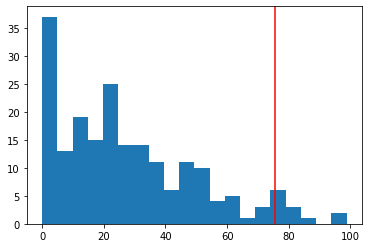

In [668]:
plt.hist(mrois_nv_perm, bins=20)
plt.axvline(x=ths_roi, color='red')

In [669]:
rej_blobs = np.zeros((num_time, num_time))

mask_cp = rej_nv; iter_blob = 0
while np.any(mask_cp):
    iter_blob += 1
    queue = [tuple(np.transpose(np.where(mask_cp))[0])]
    mask_cp[queue[0]] = False
    while len(queue) > 0:
        cur = queue.pop(0)
        rej_blobs[cur[0], cur[1]] = iter_blob
        if cur[0] > 0:
            if mask_cp[cur[0]-1, cur[1]]:
                queue.append((cur[0]-1, cur[1]))
                mask_cp[cur[0]-1, cur[1]] = False
        if cur[0] < num_time-1:
            if mask_cp[cur[0]+1, cur[1]]:
                queue.append((cur[0]+1, cur[1]))
                mask_cp[cur[0]+1, cur[1]] = False
        if cur[1] > 0:
            if mask_cp[cur[0], cur[1]-1]:
                queue.append((cur[0], cur[1]-1))
                mask_cp[cur[0], cur[1]-1] = False
        if cur[1] < num_time-1:
            if mask_cp[cur[0], cur[1]+1]:
                queue.append((cur[0], cur[1]+1))
                mask_cp[cur[0], cur[1]+1] = False
num_blobs = iter_blob

In [670]:
rois_nv = np.zeros(num_blobs+1)
for iter_blob in range(1, num_blobs+1):
    rois_nv[iter_blob] = np.sum(-np.log(pval_est[rej_blobs == iter_blob]))

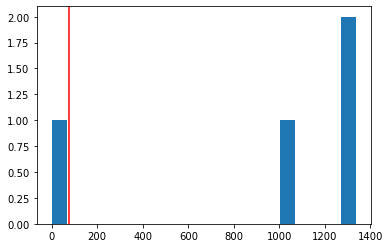

In [671]:
plt.hist(rois_nv, bins=20)
plt.axvline(x=ths_roi, color='red')

## plots

Text(0.5, 0, 'series 2 at time $s$')

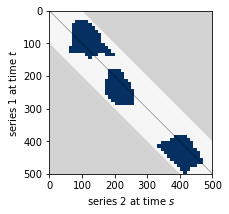

In [672]:
plt.figure(figsize=(3,3))
ldn.imshow(np.isin(rej_blobs, np.where(rois_nv > ths_roi)[0]), time=[rec_time[0], rec_time[1]], identity=True)
plt.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
plt.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')
plt.xlim(rec_time[0], rec_time[1]), plt.ylim(rec_time[1], rec_time[0])
plt.ylabel(r'series 1 at time $t$'); plt.xlabel(r'series 2 at time $s$')


([], <a list of 0 Text yticklabel objects>)

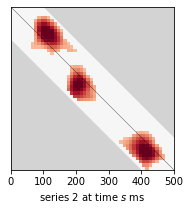

In [709]:
plt.figure(figsize=(3,3))
ldn.imshow(dspr_est[:num_time,num_time:] * np.isin(rej_blobs, np.where(rois_nv > ths_roi)[0]),
          vmax=0.0004, time=rec_time, identity=True)
plt.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
plt.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')
plt.xlim(rec_time[0], rec_time[1]), plt.ylim(rec_time[1], rec_time[0])
# plt.ylabel(r'series 1 at time $t$'); 
plt.xlabel(r'series 2 at time $s$ ms'); plt.yticks([],[])

In [674]:
np.mean(rois_nv <= mrois_nv_perm[:,None], 0)

array([1., 0., 0., 0.])

# 7. Factor Loading Animation

In [566]:
covs = [[np.cov(da) for da in dat] for dat in data]

In [567]:
loadings = [
    np.matmul(covs[0],np.reshape(weight_est[:num_time], (num_time,-1,1)))[...,0],
    np.matmul(covs[1],np.reshape(weight_est[num_time:], (num_time,-1,1)))[...,0]
]

In [568]:
%matplotlib inline
from matplotlib import animation, rc
from IPython.display import HTML

In [569]:
sigma = 0.5
weights = np.exp(-np.sum(np.square(
    np.mgrid[0:4:100j,0:4:100j][...,None]-coords_S[0].T[:,None,None,:]),
    0) / (2*sigma**2))

Text(0.5, 0, 't = 0.000sec.')

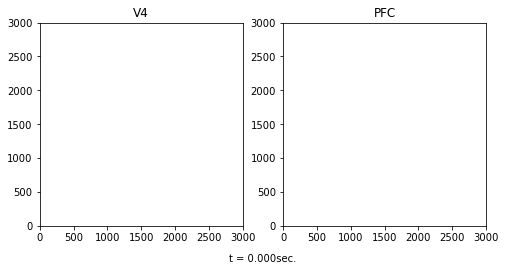

In [570]:
# First set up the figure, the axis, and the plot element we want to animate
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))

ax1.set_title("V4"); ax2.set_title("PFC")
img1 = ax1.imshow([[]], cmap='RdBu', origin='lower', extent=((0,3000,0,3000)))
img2 = ax2.imshow([[]], cmap='RdBu', origin='lower', extent=((0,3000,0,3000)))

ax3 = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("t = %.3fsec."%0)

In [571]:
# initialization function: plot the background of each frame
def init():
    img1.set_data([[]]); img1.set_clim(-0.1,0.1)
    img2.set_data([[]]); img2.set_clim(-0.1,0.1)
    return (img1,img2)

In [572]:
# animation function. This is called sequentially
def animate(i):
    n = 0
    img1.set_data((np.sum(weights*loadings[0][i],-1)/np.sum(weights,-1)).T)
    img2.set_data((np.sum(weights*loadings[1][i],-1)/np.sum(weights,-1)).T)
    ax3.set_xlabel(r't=%.3fsec.'%((i-1)/100))
    return (img1,img2)

In [573]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                                 frames=50, interval=100, blit=True)

In [574]:
HTML(anim.to_html5_video())

In [575]:
fmt = {0.25: '.25', 0.5: '.50', 0.75: '.75'}

[Text(1, 0, '0'),
 Text(1, 0, '.25'),
 Text(1, 0, '.50'),
 Text(1, 0, '.75'),
 Text(1, 0, '1')]

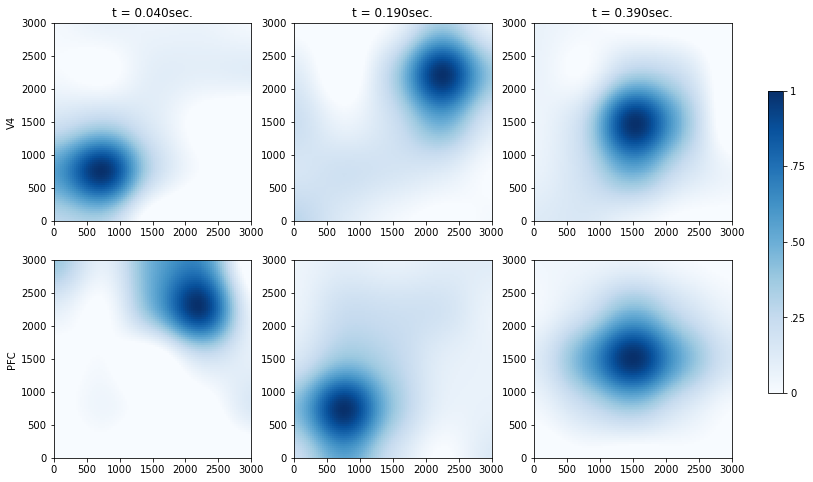

In [576]:
fig, (axes1, axes2) = plt.subplots(2, 3, figsize=(14,8))
tpts = [5, 20, 40]

for i, t in enumerate(tpts):
    (ax1,ax2) = (axes1[i], axes2[i])
    
    ax1.set_title("t = %.3fsec."%((t-1)/100))
    load_norm = [np.sum(weights*loading[t],-1)/np.sum(weights,-1)
                 for loading in loadings]
    zl = [(load/np.max(load)).T for load in load_norm]
    img1 = ax1.imshow(zl[0],
                      cmap='Blues', origin='lower', extent=((0,3000,0,3000)))
    img2 = ax2.imshow(zl[1],
                      cmap='Blues', origin='lower', extent=((0,3000,0,3000)))
    img1.set_clim(0,1)
    img2.set_clim(0,1)
    
#     ct1 = ax1.contour((np.arange(100)+0.5)*30, (np.arange(100)+0.5)*30,
#             zl[0], levels=[0.25, 0.5, 0.75], linewidths=0.2, colors=['black'])
#     ax1.clabel(ct1, ct1.levels, fmt=fmt, inline=True, fontsize=10)
#     ct2 = ax2.contour((np.arange(100)+0.5)*30, (np.arange(100)+0.5)*30,
#             zl[1],  levels=[0.25, 0.5, 0.75], linewidths=0.2, colors=['black'])
#     ax2.clabel(ct2, ct2.levels, fmt=fmt, inline=True, fontsize=10)
    
    if i == 0:
        ax1.set_ylabel("V4")
        ax2.set_ylabel("PFC")
        
fig.subplots_adjust(right=0.8)

ax_cb = fig.add_axes([0.75, 0.15, 0.1, 0.7])
ax_cb.axis('off')
cb = plt.colorbar(ax2.get_images()[0], ticks=[0, 0.25, 0.5, 0.75, 1])
cb.ax.set_yticklabels(['0','.25','.50','.75','1'])

# 8. Granger Causality

In [675]:
bw = 10
order = 5
lambda_reg = lambda_diag # 1.5
lags_cond = np.array([1,2])

In [676]:
GC_ar = np.zeros([num_time, 2])

In [677]:
for end_time in np.arange(bw, num_time):
    Sigma_tw = (Sigma_est.reshape([2,num_time,2,num_time])
        [:,end_time-bw:end_time,:,end_time-bw:end_time])

    Sigma_ar = np.mean([Sigma_tw[:,i+order:i:-1,:,i+order:i:-1] 
        for i in np.arange(bw-order)], 0).reshape((2*order,2*order))
    
    id_ar1 = np.concatenate([np.arange(order),lags_cond+order])
    id_ar2 = np.concatenate([np.arange(order)+order,lags_cond])
    id_ar12 = np.concatenate([np.arange(order),np.arange(1,order)+order])
    id_ar21 = np.concatenate([np.arange(order)+order,np.arange(1,order)])
    
    lcov_ar1 = Sigma_ar[np.ix_(id_ar1,id_ar1)]
    lcov_ar2 = Sigma_ar[np.ix_(id_ar2,id_ar2)]
    lcov_ar12 = Sigma_ar[np.ix_(id_ar12,id_ar12)]
    lcov_ar21 = Sigma_ar[np.ix_(id_ar21,id_ar21)]
    
    lcov_ar1 = lcov_ar1 + lambda_reg * np.eye(lcov_ar1.shape[0])
    lcov_ar2 = lcov_ar2 + lambda_reg * np.eye(lcov_ar2.shape[0])
    lcov_ar12 = lcov_ar12 + lambda_reg * np.eye(lcov_ar12.shape[0])
    lcov_ar21 = lcov_ar21 + lambda_reg * np.eye(lcov_ar21.shape[0])

    mse_ar1 = lcov_ar1[0,0] - lcov_ar1[0,1:]@np.linalg.inv(lcov_ar1[1:,1:])@lcov_ar1[0,1:]
    mse_ar2 = lcov_ar2[0,0] - lcov_ar2[0,1:]@np.linalg.inv(lcov_ar2[1:,1:])@lcov_ar2[0,1:]

    mse_ar12 = lcov_ar12[0,0] - lcov_ar12[0,1:]@np.linalg.inv(lcov_ar12[1:,1:])@lcov_ar12[0,1:]
    mse_ar21 = lcov_ar21[0,0] - lcov_ar21[0,1:]@np.linalg.inv(lcov_ar21[1:,1:])@lcov_ar21[0,1:]
    
    GC_ar[end_time] = (np.log(mse_ar1) - np.log(mse_ar12), 
                       np.log(mse_ar2) - np.log(mse_ar21))

## permutation bootstrap

In [678]:
num_perm = Sigmas_perm.shape[0]
GCs_perm = np.zeros([num_perm, num_time, 2])

In [679]:
for iter_perm in np.arange(num_perm):
    for end_time in np.arange(bw, num_time):
        Sigma_tw = (Sigmas_perm[iter_perm].reshape([2,num_time,2,num_time])
            [:,end_time-bw:end_time,:,end_time-bw:end_time])

        Sigma_ar = np.mean([Sigma_tw[:,i+order:i:-1,:,i+order:i:-1] 
            for i in np.arange(bw-order)], 0).reshape((2*order,2*order))

        id_ar1 = np.concatenate([np.arange(order),lags_cond+order])
        id_ar2 = np.concatenate([np.arange(order)+order,lags_cond])
        id_ar12 = np.concatenate([np.arange(order),np.arange(1,order)+order])
        id_ar21 = np.concatenate([np.arange(order)+order,np.arange(1,order)])

        lcov_ar1 = Sigma_ar[np.ix_(id_ar1,id_ar1)]
        lcov_ar2 = Sigma_ar[np.ix_(id_ar2,id_ar2)]
        lcov_ar12 = Sigma_ar[np.ix_(id_ar12,id_ar12)]
        lcov_ar21 = Sigma_ar[np.ix_(id_ar21,id_ar21)]

        lcov_ar1 = lcov_ar1 + lambda_reg * np.eye(lcov_ar1.shape[0])
        lcov_ar2 = lcov_ar2 + lambda_reg * np.eye(lcov_ar2.shape[0])
        lcov_ar12 = lcov_ar12 + lambda_reg * np.eye(lcov_ar12.shape[0])
        lcov_ar21 = lcov_ar21 + lambda_reg * np.eye(lcov_ar21.shape[0])

        mse_ar1 = lcov_ar1[0,0] - lcov_ar1[0,1:]@np.linalg.inv(lcov_ar1[1:,1:])@lcov_ar1[0,1:]
        mse_ar2 = lcov_ar2[0,0] - lcov_ar2[0,1:]@np.linalg.inv(lcov_ar2[1:,1:])@lcov_ar2[0,1:]

        mse_ar12 = lcov_ar12[0,0] - lcov_ar12[0,1:]@np.linalg.inv(lcov_ar12[1:,1:])@lcov_ar12[0,1:]
        mse_ar21 = lcov_ar21[0,0] - lcov_ar21[0,1:]@np.linalg.inv(lcov_ar21[1:,1:])@lcov_ar21[0,1:]

        GCs_perm[iter_perm,end_time] = \
            (np.log(mse_ar1) - np.log(mse_ar12), 
             np.log(mse_ar2) - np.log(mse_ar21))

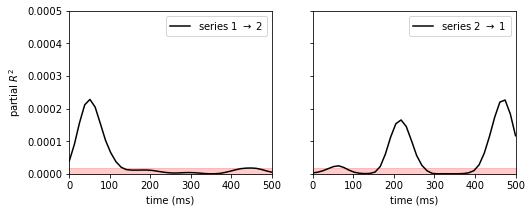

In [696]:
plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
plt.plot(np.linspace(0,500,num_time-bw), #np.arange(num_time-bw)*5+bw*2.5,
         GC_ar[bw:,1], label=r'series 1 $\rightarrow$ 2', color='black')
plt.fill_between(
    np.linspace(0,500,num_time-bw), #np.arange(num_time-bw)*5+bw*2.5,
    np.quantile(np.max(GCs_perm[:,bw:,0],1),0.95,0),
    color='red', alpha=0.2)
# plt.fill_between([0,50],[0.001,0.001],color='grey',alpha=1)
# plt.fill_between([450,500],[0.001,0.001],color='grey',alpha=1)
plt.ylim(0, 0.0005); plt.xlim(0, 500)
plt.ylabel(r"partial $R^2$"); plt.xlabel("time (ms)"); plt.legend()
# plt.title(r"Granger Causality from PFC to V4")

plt.subplot(1,2,2)
plt.plot(np.linspace(0,500,num_time-bw), #np.arange(num_time-bw)*5+bw*2.5,
         GC_ar[bw:,0], label=r'series 2 $\rightarrow$ 1', color='black')
plt.fill_between(
    np.linspace(0,500,num_time-bw),
    # np.arange(num_time-bw)*5+bw*2.5,
    np.quantile(np.max(GCs_perm[:,bw:,1],1),0.95,0),
    color='red', alpha=0.2)
# plt.fill_between([0,50],[0.001,0.001],color='grey',alpha=1)
# plt.fill_between([450,500],[0.001,0.001],color='grey',alpha=1)
plt.ylim(0, 0.0005); plt.xlim(0, 500)
plt.ylabel(r""); plt.xlabel("time (ms)"); plt.legend()
plt.tick_params('y', labelleft=False)